In [19]:
import os
from glob import glob 
import random
import shutil
import numpy as np
from pydub import AudioSegment
import tensorflow as tf
import time
from skimage import io, transform
import matplotlib.pyplot as plt

In [2]:
def two_files_audio_sum(file_1_path, file_2_path,file_sum_name, volume_reduction=0):
    s1 = AudioSegment.from_file(file_1_path)
    s2 = AudioSegment.from_file(file_2_path) - volume_reduction # volume_reduction in dB

    s2_shift = (len(s1)-len(s2)) / 2 if len(s1) > len(s2) else 0
    
    audio_sum = s1.overlay(s2, position=s2_shift)
    audio_sum.export(file_sum_name, format='wav')

    return np.array(audio_sum.get_array_of_samples())

In [3]:
mixed_samples=two_files_audio_sum('./bbaf1n.wav','./bbaf2s.wav','./mixed_audio.wav')

FileNotFoundError: [Errno 2] No such file or directory: './bbaf1n.wav'

In [4]:
from scipy.io import wavfile
from scipy import signal
import math

In [5]:
def downsampling(samples, sample_rate, downsample_rate):
    secs = len(samples) / float(sample_rate)
    num_samples = int(downsample_rate * secs)

    return signal.resample(samples, num_samples)

In [9]:
def compute_spectrograms(audio_file, max_audio_length=480000, sample_rate=16e3, n_fft=512, window_size=25, step_size=10):
    
    
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_samples = np.zeros((1, max_audio_length + n_fft//2))
    
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_samples[0, n_fft//2: len(samples) + n_fft//2] = samples
    num_frames = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_samples, dtype=tf.float32)
        # Compute STFT
        specs_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size,
                                              fft_length=n_fft, pad_end=True)
        # Apply power-law compression
        specs_tensor = tf.abs(specs_tensor) ** 0.3
    
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False)) as sess:
            specs = sess.run(specs_tensor)

    return specs, num_frames

In [16]:
a = time.time()
s,n=compute_spectrograms('/Users/manideepkolla/Downloads/test_fold/pretrain/5549779787693549159/00008.wav')
b = time.time()
print(b-a)

0.21938800811767578


In [18]:
useful_frames.shape

(1058, 257)

In [11]:
useful_frames=s[0][:n,:]

In [12]:
import seaborn as sns
sns.set()

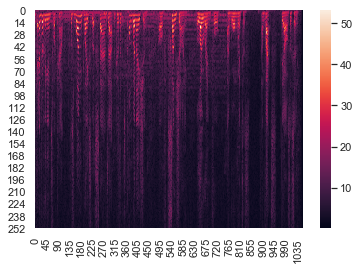

In [13]:
ax = sns.heatmap(np.rollaxis(useful_frames,1,0))

In [20]:
spect = io.imread('/Users/manideepkolla/Downloads/test_fold/output/5549779787693549159_00001_4/mixed_spectrogram.png')

In [21]:
spect.shape

(10, 10, 3)

In [23]:
useful_frames.shape

(1058, 257)

In [24]:
np.save('a.npy',useful_frames)

In [26]:
a = np.load('a.npy')

In [27]:
a.shape

(1058, 257)

In [29]:
useful_frames.all() == a.all()

True